# GOURMET GURU RESTAURANT RECOMMENDER SYSTEM
***

## 1. BUSINESS UNDERSTANDING
***

### 1.1 Overview

The U.S. dining industry is rich and varied, yet locals and tourists often find it difficult to discover restaurants that meet their specific preferences. The abundance of options, without a centralized platform for personalized recommendations, complicates the decision-making process. Our system addresses this by offering tailored dining suggestions, enhancing user experience and supporting local businesses.

### 1.2 Stakeholder Definition

- The main stakeholder in this project is Gourmet Guru, a start up aiming to venture into the restaurant recommendation business.

They have contracted us, Digital Delight to come up with a solution.

### 1.3 PROBLEM STATEMENT

As the dining industry expands, consumers are overwhelmed by the numerous restaurant options, making it difficult to find establishments that match their preferences. The absence of a centralized platform for personalized recommendations complicates decision-making, especially for those in unfamiliar areas. Existing solutions are too generalized and lack real-time, location-based suggestions. As the dining scene diversifies, there's an urgent need for an intelligent recommender system to provide tailored, real-time dining suggestions, enhancing the overall experience.

### 1.4 OBJECTIVES

#### 1.4.1 Main Objective

Develop a user-friendly restaurant recommender system that provides personalized, real-time suggestions based on user location and cuisine preferences. The system will utilize various data sources to ensure accurate and relevant recommendations.

#### 1.4.2 Specific Objectives

- Identifying and evaluating the key attributes and factors that significantly influence restaurant ratings and customer preferences.
- To develop a content based recommendation system that can generate personalized restaurant recommendation based on restaurant attributes.
- To develop a collaborative based recommendation system that would generate recommendations based on prior restaurant ratings.
- Create an intuitive, responsive web and mobile application that recommends based on content or collaborative filtering.

### 1.5 METRICS OF SUCCESS

Metrics of Success will include:

- RMSE : This will  measure the average magnitude of the errors between predicted values and actual values, providing an indication of how well a model performs. 

- Recommendation Accuracy: Evaluated through user feedback and satisfaction scores, focusing on how well the recommendations match user preferences.

***
## 2. DATA UNDERSTANDING
***
The data used in this project was sourced by the stakeholders from [YELP](https://www.yelp.com/dataset/download). It is a collective dataset of various businesses and user information gotten from Yelp's website. It contains 6,990,280 reviews, 150,346 businesses, 200,100 pictures across 11 metropolitan areas and 19 states. 
The original data was filtered by concentrating only on restaurant businesses and on reviews made within the year and split into two datasets as shown 
[here](Preliminary_notebook.ipynb).

The two datasets have information on 
> 1. Restaurant Informational Data
> 2. User Review Data

Data Understanding on the two datasets are as follows::

In [1]:
# importing libraries
import os
import re
import sys
import pickle
import numpy as np
import pandas as pd
from classes.understanding import DataLoader, DataChecks, DataInfo
from classes.EDA import UnivariateAnalysis, BivariateAnalysis, ComprehensiveEDA, UserEDA

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Text processing 
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning and model selection
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from surprise import Dataset, Reader, SVD, accuracy, NormalPredictor,NMF
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split 

# Deep learning with TensorFlow
from tensorflow.keras import models, layers, optimizers, losses, regularizers, metrics


ModuleNotFoundError: No module named 'surprise'

#### i) Restaurant Informational Data

In [2]:
# Instantiate the DataLoader class
loader= DataLoader()

# Instantiate the DataInfo class
summary= DataInfo()

In [3]:
# Reading the restaurants csv file
restaurant_data= loader.read_data("data/restaurants.csv")

# Summary information on the restaurant df
print(f'\nRESTAURANT DATASET INFORMATION\n' + '=='*20 + '\n')
summary.info(restaurant_data)


RESTAURANT DATASET INFORMATION

Shape of the dataset : (52286, 14) 

Column Names
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object') 
 

Data Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52286 entries, 0 to 52285
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   52286 non-null  object 
 1   name          52286 non-null  object 
 2   address       51843 non-null  object 
 3   city          52286 non-null  object 
 4   state         52286 non-null  object 
 5   postal_code   52265 non-null  object 
 6   latitude      52286 non-null  float64
 7   longitude     52286 non-null  float64
 8   stars         52286 non-null  float64
 9   review_count  52286 non-null  int64  
 10  is_open       52286 non-null  int64  
 11  attributes    51720

,latitude,longitude,stars,review_count,is_open
count,52286.000000,52286.000000,52286.000000,52286.000000,52286.000000
mean,36.997663,-87.845038,3.515234,87.241078,0.669472
std,6.010943,13.813532,0.829585,188.912445,0.470408
min,27.564457,-120.083748,1.000000,5.000000,0.000000
25%,32.217586,-90.233506,3.000000,13.000000,0.000000
50%,39.484140,-86.035621,3.500000,33.000000,1.000000
75%,39.958370,-75.337533,4.000000,89.000000,1.000000
max,53.679197,-74.664459,5.000000,7568.000000,1.000000


Dataset Overview


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': ""u'full_bar'"", '...","Pubs, Restaurants, Italian, Bars, American (Tr...",NaN


### Restaurant Dataset Column Descriptions
***

| Column Name     | Description                                                                 |
|-----------------|-----------------------------------------------------------------------------|
| business_id     | Unique identifier for the business.                                         |
| name            | Name of the business.                                                       |
| address         | Street address of the business.                                             |
| city            | City where the business is located.                                         |
| state           | State where the business is located.                                        |
| postal_code     | Postal code (ZIP code) of the business location.                            |
| latitude        | Latitude coordinate of the business location.                               |
| longitude       | Longitude coordinate of the business location.                              |
| stars           | Average star rating of the (typically on a scale of 1 to 5).       |
| review_count    | Number of reviews the business has received.                                |
| is_open         | Indicator of whether the business is currently open (1 = open, 0 = closed). |
| attributes      | Additional attributes of the business (e.g., "WiFi: free", "HasTV: true").  |
| categories      | List of categories the business belongs to (e.g., "Restaurants", "Bars").   |
| hours           | Business hours (e.g., "Monday: 8am-5pm, Tuesday: 8am-5pm").                 |


In [4]:
# Instantiating Datachecks for restaurant df
checks= DataChecks(restaurant_data)

# Checking for duplicates
checks.check_duplicates()

NO DUPLICATES FOUND


In [5]:
# Checking for null values in restaurant dataset
checks.check_missing()

,Column Names,Missing Values,Percentage Missing
0,address,443,0.847263
1,postal_code,21,0.040164
2,attributes,566,1.082508
3,hours,7279,13.921509


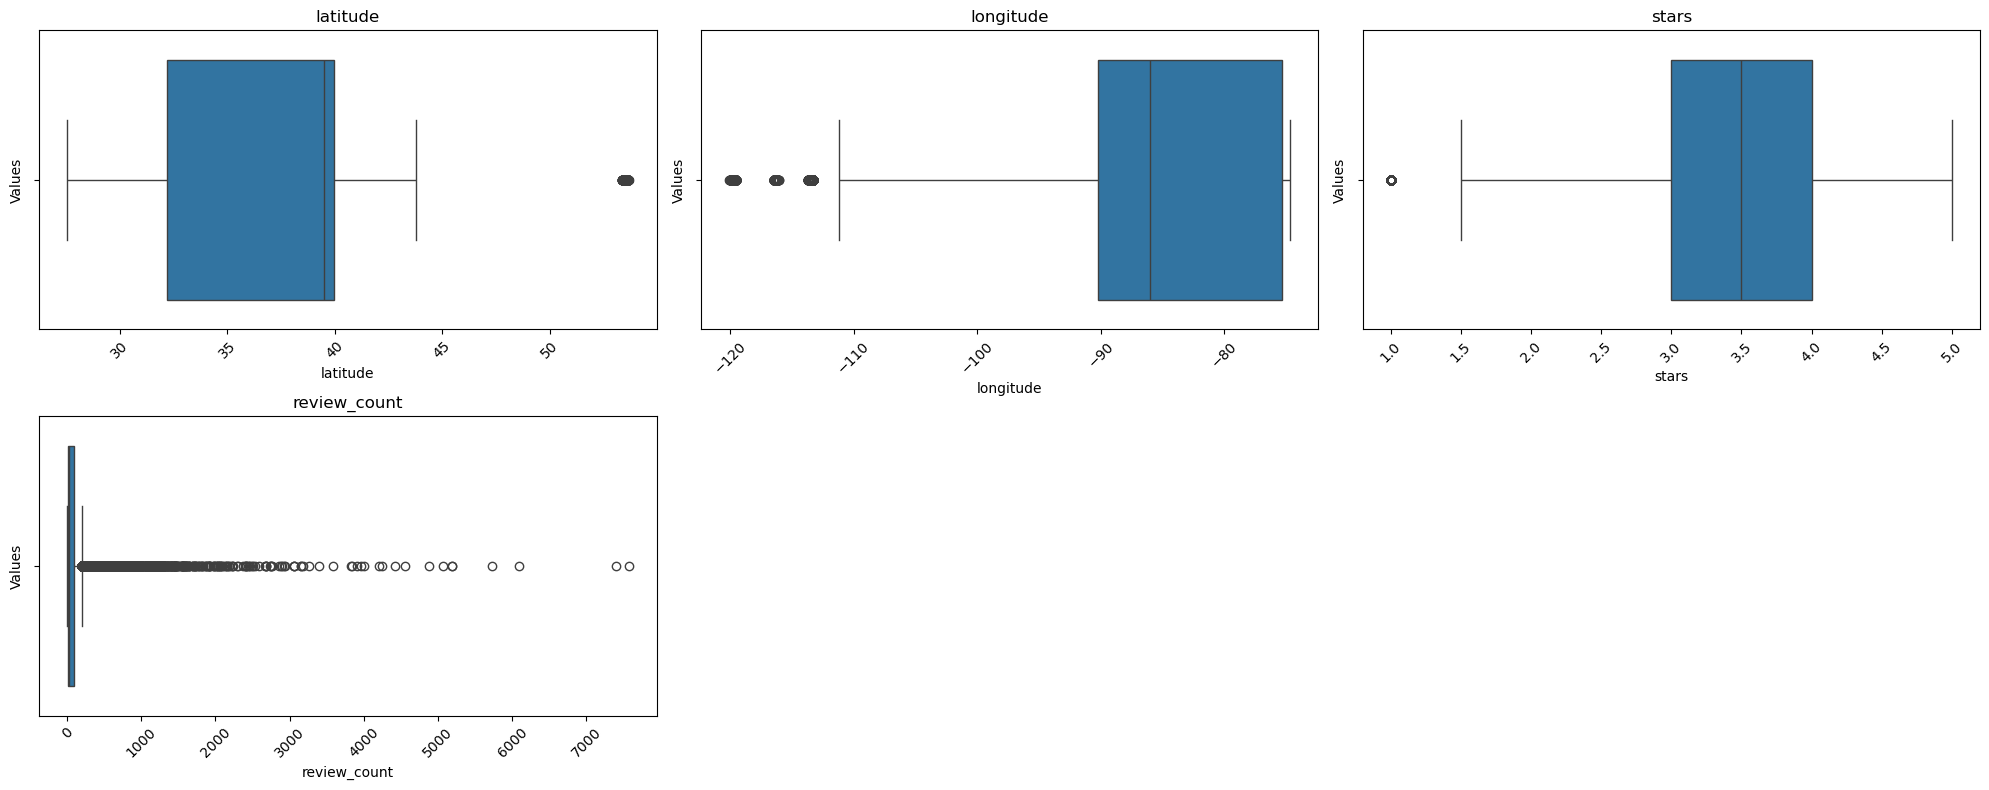

In [6]:
# check for outliers in restaurant dataset
checks.check_outliers_and_plot()

***
**Initial Observations on restaurant information data**
***
- > Restaurant information dataset has 52286 rows and 14 columns.
- > All business locations are in the North West hemisphere i.e. USA based on min and max latitude and longitude.
- > The address, 	postalcode, attributes and hours columns contain missing values and will be addressed.
- > There are no duplicated rows.
- > Majority of the businesses receive between 3-4 stars on average.
- > No significant outliers can be seen.urs

#### ii) User Review Data

In [7]:
# Loading the users csv file
users_data= loader.read_data("data/users.csv")

# Summary information on the user review data
print(f'\nUSER DATASET INFORMATION\n' + '=='*20 + '\n')
summary.info(users_data)


USER DATASET INFORMATION

Shape of the dataset : (429771, 9) 

Column Names
Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object') 
 

Data Summary
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429771 entries, 0 to 429770
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_id    429771 non-null  object
 1   user_id      429771 non-null  object
 2   business_id  429771 non-null  object
 3   stars        429771 non-null  int64 
 4   useful       429771 non-null  int64 
 5   funny        429771 non-null  int64 
 6   cool         429771 non-null  int64 
 7   text         429771 non-null  object
 8   date         429771 non-null  object
dtypes: int64(4), object(5)
memory usage: 29.5+ MB

Descriptive Statistics


,stars,useful,funny,cool
count,429771.000000,429771.000000,429771.000000,429771.000000
mean,3.820449,0.822806,0.212450,0.487885
std,1.513978,2.818655,1.231838,2.382432
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,261.000000,101.000000,164.000000


Dataset Overview


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,iBUJvIOkToh2ZECVNq5PDg,iAD32p6h32eKDVxsPHSRHA,YB26JvvGS2LgkxEKOObSAw,5,0,0,0,I've been eating at this restaurant for over 5...,2021-01-08 01:49:36
1,HgEofz6qEQqKYPT7YLA34w,rYvWv-Ny16b1lMcw1IP7JQ,jfIwOEXcVRyhZjM4ISOh4g,1,0,0,0,How does a delivery person from here get lost ...,2021-01-02 00:19:00
2,Kxo5d6EOnOE-vERwQf2a1w,2ntnbUia9Bna62W0fqNcxg,S-VD26LE_LeJNx5nASk_pw,5,0,0,0,"The service is always good, the employees are ...",2021-01-26 18:01:45


### Users Reviews Dataset Column Descriptions
***
| Column Name  | Description                                                                 |
|--------------|-----------------------------------------------------------------------------|
| review_id    | Unique identifier for the review.                                           |
| user_id      | Unique identifier for the user who wrote the review.                        |
| business_id  | Unique identifier for the business that the review is associated with.      |
| stars        | Star rating given by the user in the review (on a scale of 1 to 5).         |
| useful       | Count of how many users found the review useful.                            |
| funny        | Count of how many users found the review funny.                             |
| cool         | Count of how many users found the review cool.                              |
| text         | The content of the review written by the user.                              |
| date         | Date when the review was written.                                           |


In [8]:
# Instantiating Datachecks for users df
checks= DataChecks(users_data)

# Checking for duplicates for users df
checks.check_duplicates()


NO DUPLICATES FOUND


In [9]:
# Checking for null values in users df
checks.check_missing()

NO NULL VALUES FOUND


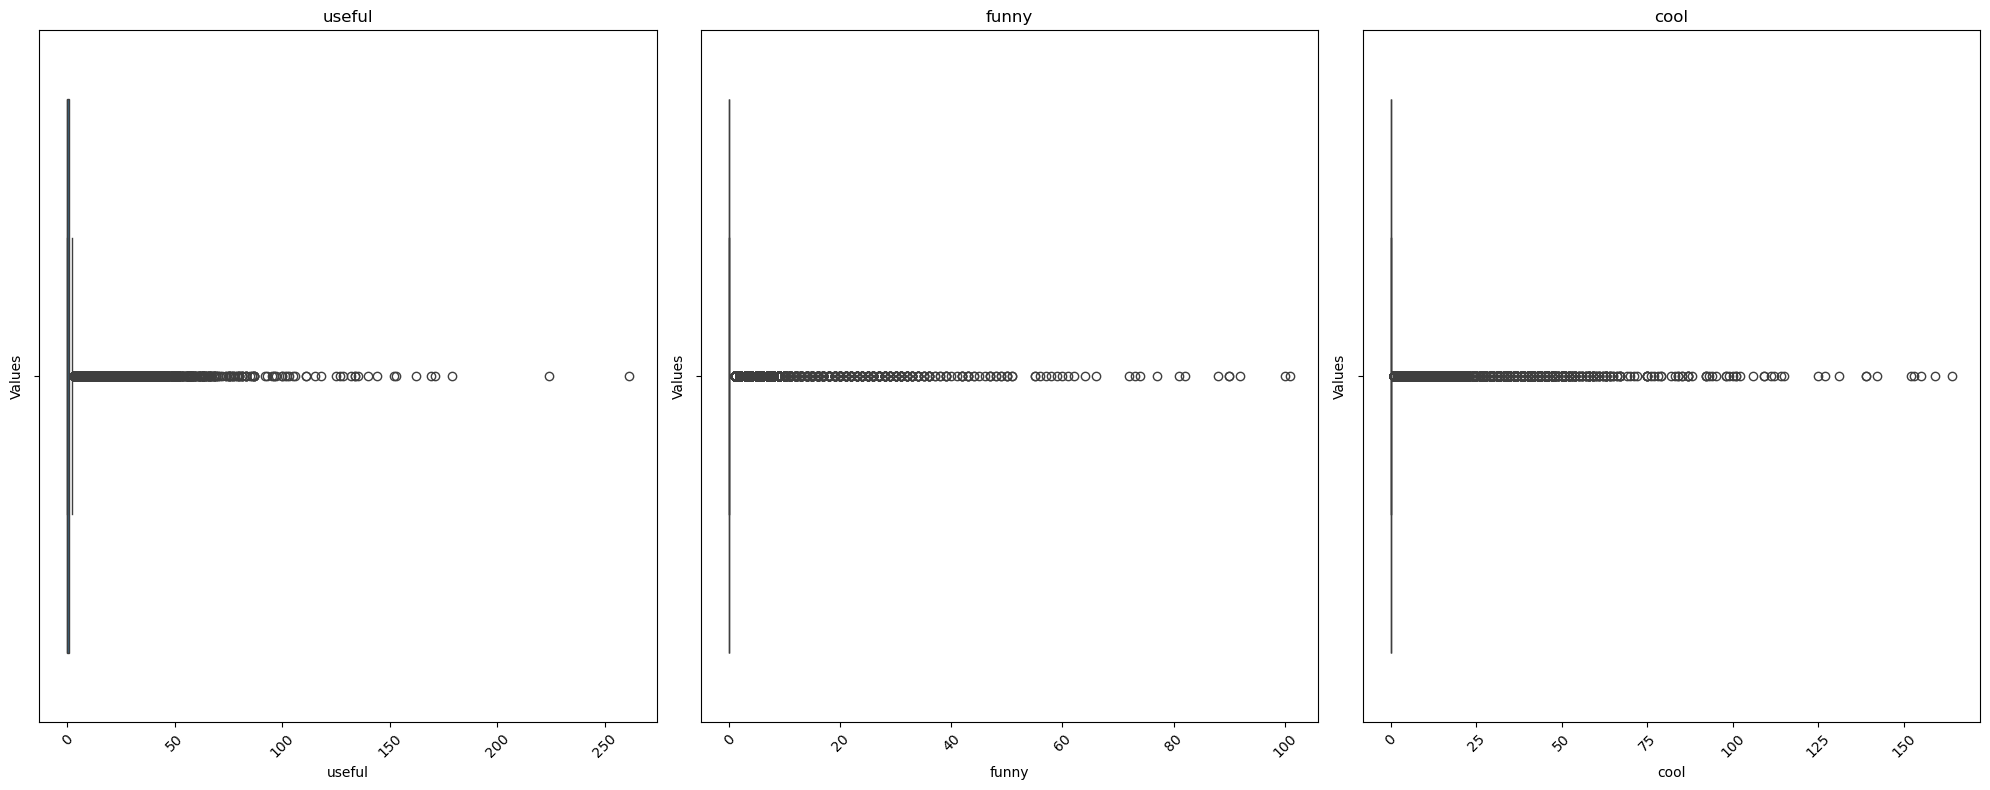

In [10]:
# check for outliers in users df
checks.check_outliers_and_plot()

***
**Initial Observations on user review data**
***
> The user review dataset contains 2559586 rows and 4 columns

> There is evidence of duplicated data and would require cleaning

> There are no null values in the dataset.

> Majority of users rate restaurants between 3 and 4 stars

> useful, funny and cool columns do not seem to show any relevant information

***
## Exploratory Data Analysis Using `EDA.py` Classes
***

In this section of the notebook, we will initiate the exploratory data analysis by instantiating the classes defined in our `EDA.py` script. These classes are designed to facilitate the visualization of various features within the `restaurants.csv` dataset, aiding in our understanding of the data's structure and trends.

The analysis is split between:

    i)  Univartiate Analysis of restaurant data
    
    ii) Bivariate analysis  of restaurant data

    iii) Analysis on User Reviews data

In [11]:
# Append the path where the EDA modules are located to sys.path
sys.path.append(os.path.abspath('EDA'))


### i) Univariate Analysis of Restaurant data
***

We first perform our univariate EDA on the `restaurants.csv` dataset to examine each variable independently. 


- **Star Ratings (`stars`)**: Histogram of star ratings offer insights into the overall quality as perceived by customers, helping identify general satisfaction levels.
- **State Distribution (`state`)**: Bar charts showing the number of restaurants per state reveal geographical market saturation and potential areas for business expansion.
- **Operational Status (`is_open`)**: Pie charts of open vs closed status provide a snapshot of the business landscape, indicating the proportion of actively operating restaurants.


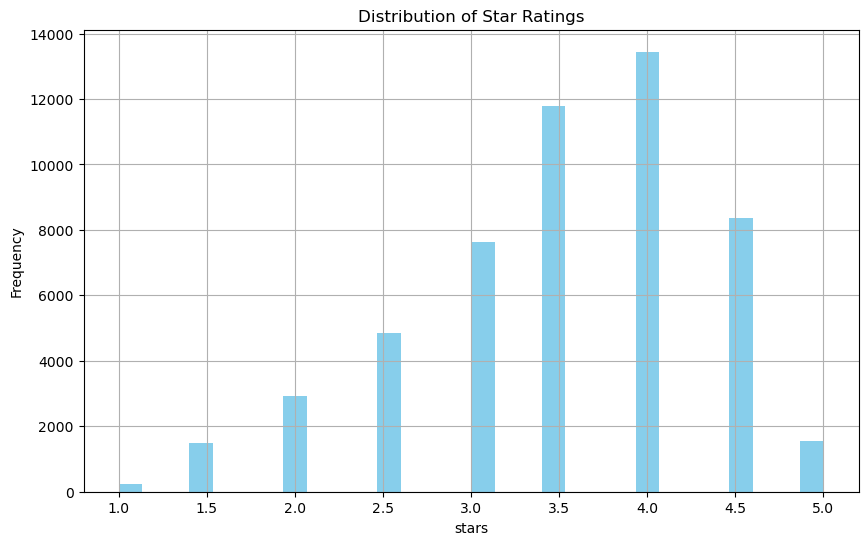

In [12]:
# Instantiate the UnivariateAnalysis class with the DataFrame
uni_analysis = UnivariateAnalysis(restaurant_data)

# Plotting the histogram of review counts
uni_analysis.plot_histogram('stars', 'Distribution of Star Ratings')

**Observations**
***

Most common ratings are 4.0 and 3.5 stars, indicating general satisfaction.

Ratings below 2.5 stars are uncommon, showing few very poor experiences.

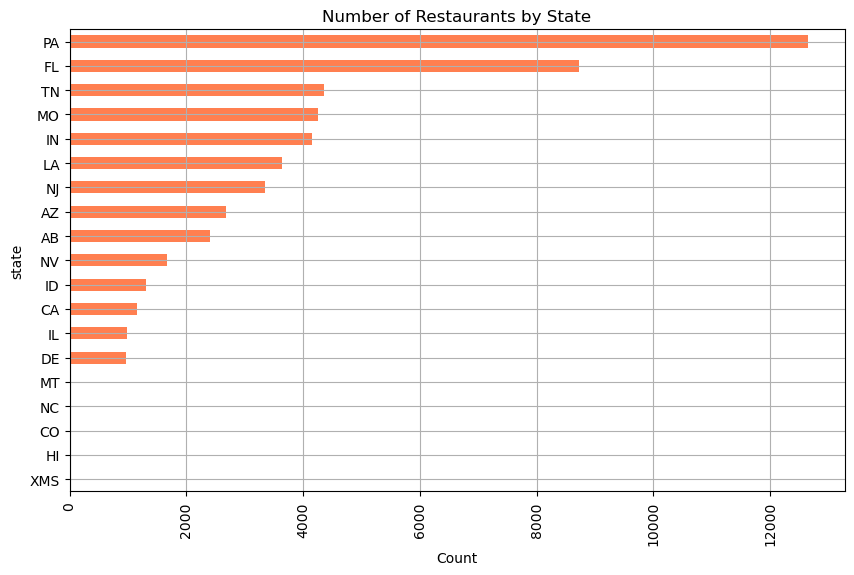

In [13]:
# Plotting the bar chart for the number of restaurants by state
uni_analysis.plot_bar_chart('state', 'Number of Restaurants by State', horizontal=True, descending=False)

**Observations**
***

Pennsylvania (PA), Florida (FL) and Tennessee (TN) boast the highest numbers of restaurants among the states, highlighting them as major markets for the restaurant industry. 

Conversely, there is a noticeable decrease in restaurant counts moving from left to right in the graph. States like North Carolina (NC), Colorado (CO), Hawaii (HI), and Montana (MT) demonstrate lack of a complete dataset in these regions. 

Understanding these patterns can help tailor location-based strategies in the restaurant recommendation system to optimize user experiences and business growth.

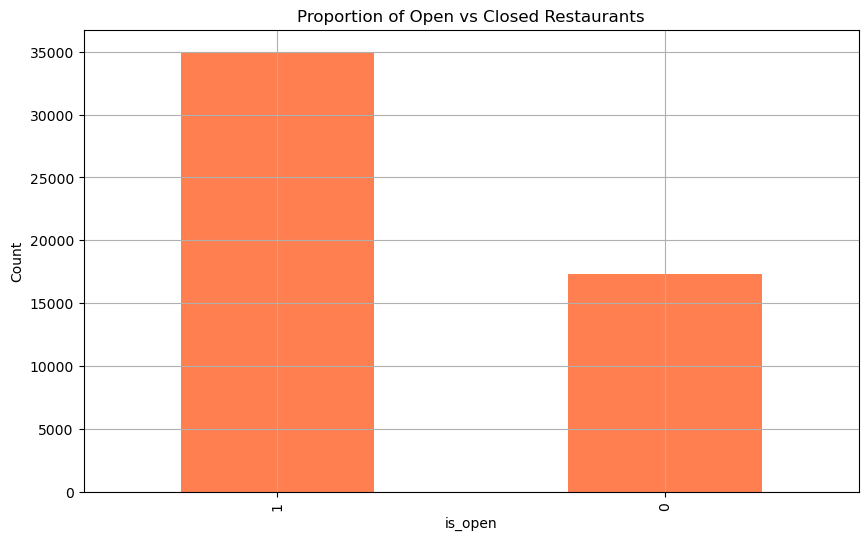

In [14]:
# Plotting the pie chart for the proportion of open vs closed restaurants
uni_analysis.plot_bar_chart('is_open', 'Proportion of Open vs Closed Restaurants')

**Observations**
***

- **66.9% Open Restaurants**: A significant majority of the restaurants in our dataset are currently operational. This proportion suggests a robust industry where the majority of listed entities are active, presenting numerous options for recommendations.

- **33.1% Closed Restaurants**: A substantial portion of the restaurants are no longer in operation. This data is crucial for ensuring accuracy in our recommendation system by filtering out closed establishments, thereby improving user experience and system reliability.

**Strategic Recommendations:**
***
 Regular updates and verification processes are necessary to maintain the accuracy of the system, ensuring that closed restaurants are removed from active recommendation lists.


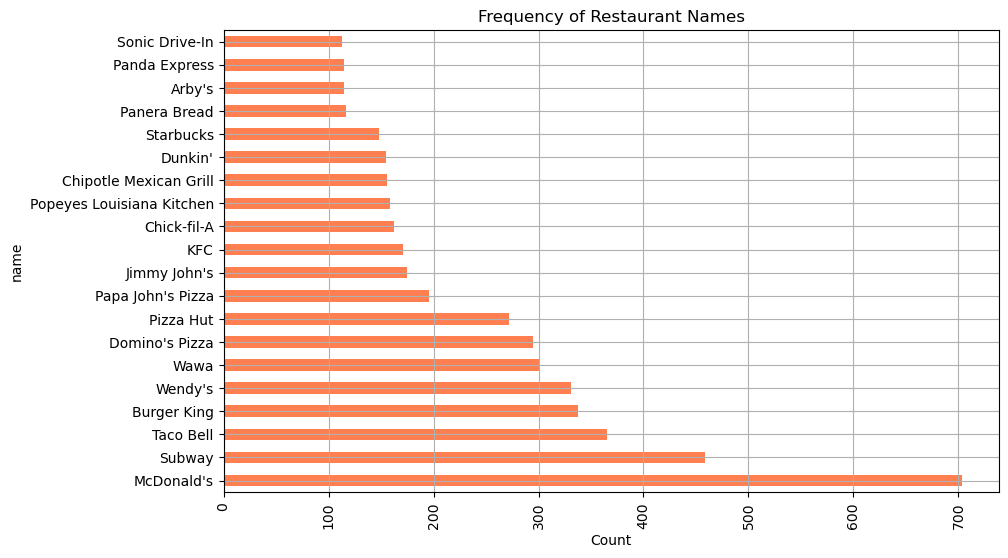

In [16]:
# Plot on most common restaurant names in dataset
uni_analysis.plot_bar_chart('name', 'Frequency of Restaurant Names', limit=20, horizontal=True, descending=True)

**Observations**
***

McDonald's, Subway, and Taco Bell lead in frequency, indicating a high presence of these chains within the dataset. This suggests a dominance of fast-food chains in the restaurant landscape.

The frequency of well-known names like Wendy's, Domino's Pizza, and Pizza Hut reflects their popularity, which can be leveraged in recommending familiar choices to users of the recommendation system.

**Strategic Implications**: 
***

Understanding which brands are most common can help tailor marketing strategies within the recommendation system, highlighting promotions, deals, or new menu items from these popular chains.


### ii) Bivariate Analysis of the Restaurant Data
***

In this section, we use the `BivariateAnalysis` class to explore relationships between pairs of variables in the `restaurants.csv` dataset. By examining these relationships, we aim to uncover patterns and correlations that can inform better decision-making for restaurant recommendations and business strategies.



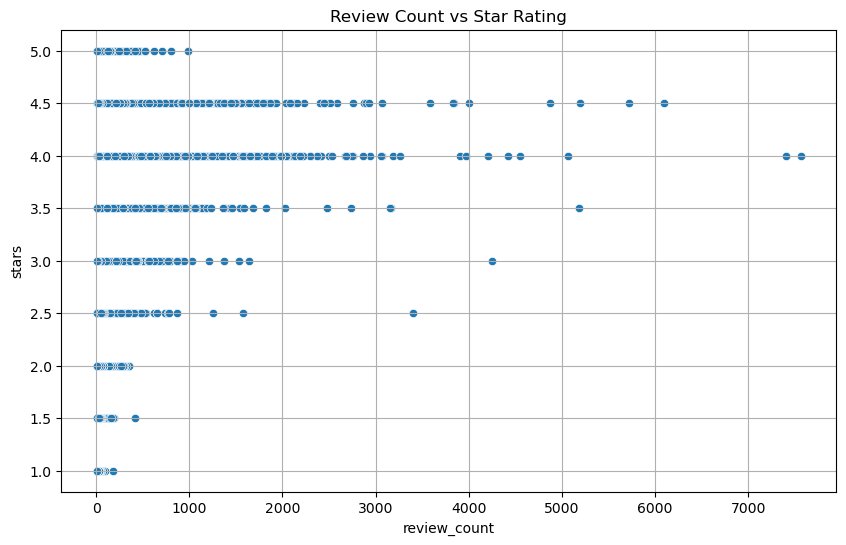

In [16]:
# Instantiate the BivariateAnalysis class with the DataFrame
bi_analysis = BivariateAnalysis(restaurant_data)

# Plotting the scatter plot to explore correlations between review counts and star ratings
bi_analysis.plot_scatter('review_count', 'stars', 'Review Count vs Star Rating')

**Observations**
***

 Higher review counts are more commonly associated with mid to high ratings (3.0 to 5.0 stars).

The highest review counts appear at 4.0 and 5.0 star ratings, suggesting high customer engagement with top-rated restaurants.

Restaurants with ratings between 1.0 and 2.5 stars tend to have fewer reviews, indicating less engagement or fewer customers.

The vertical spread at each rating level, especially at high ratings, indicates variability in the popularity of restaurants with similar ratings.


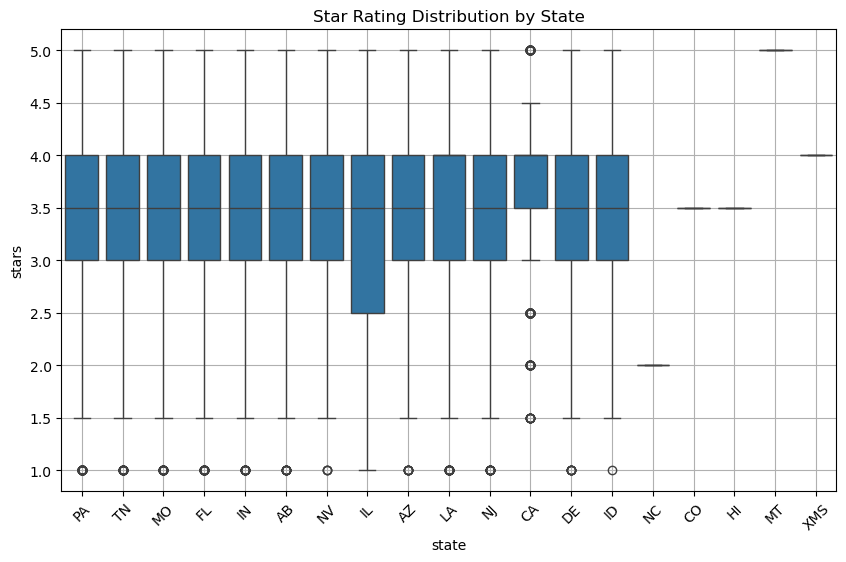

In [17]:
# Plotting the boxplot to analyze how star ratings vary across different states
bi_analysis.plot_boxplot('state', 'stars', 'Star Rating Distribution by State')

### Observations 

 The majority of states have a median star rating around 4.0, indicating generally positive reviews. States like Pennsylvania (PA), Florida (FL), and California (CA) show consistent ratings with narrow interquartile ranges (IQR), suggesting stable restaurant quality.

 Some states, such as Illinois (IL) and Delaware (DE), exhibit a wider IQR, indicating greater variability in restaurant ratings. 

### Implications for the Recommendation System

- **Consistency**: States with consistent ratings are more likely to provide reliable recommendations, as users can expect a certain level of quality across restaurants.
- **High Variation**: In states with high variability, additional filters or more personalized recommendations may be necessary to better match users with restaurants that meet their expectations.




### iii) Analysis on User Reviews data
***

Next, we'll perform EDA on the users.csv dataset. The analysis will help in enhancing our understanding of the user dynamics within our platform, guiding strategic decisions and improvements.
This analysis centered on the distribution of ratings across users and a trend analysis on frequency of reviews

In [18]:
# Instantiate the ComprehensiveEDA class with the users DataFrame
eda_users = ComprehensiveEDA(users_data)

# Instantiate the UserEDA class specifically designed for user-related data analysis
user_eda = UserEDA(users_data)

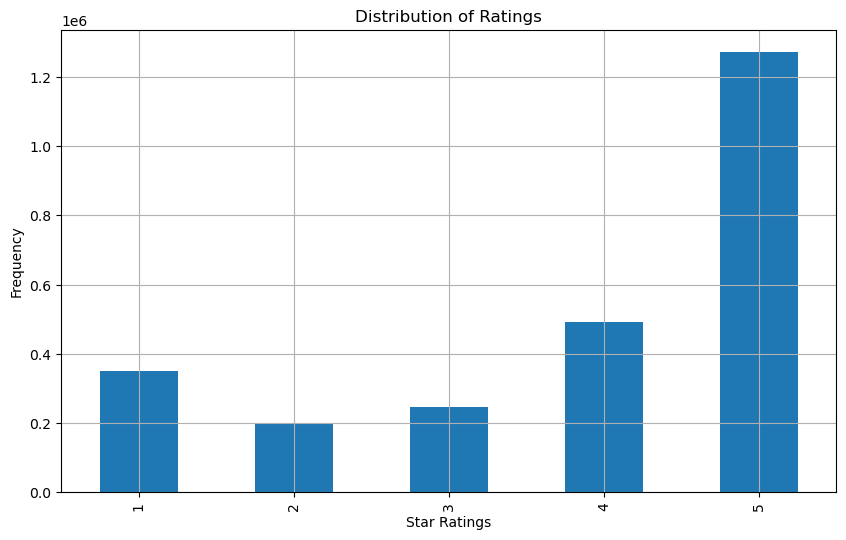

In [19]:
# plotting the rating distribution
user_eda.plot_rating_distribution()

**Observations**
***
The distribution of ratings from the users.csv dataset reveals a notable preference for higher ratings, with 5-star ratings significantly more frequent than others. 

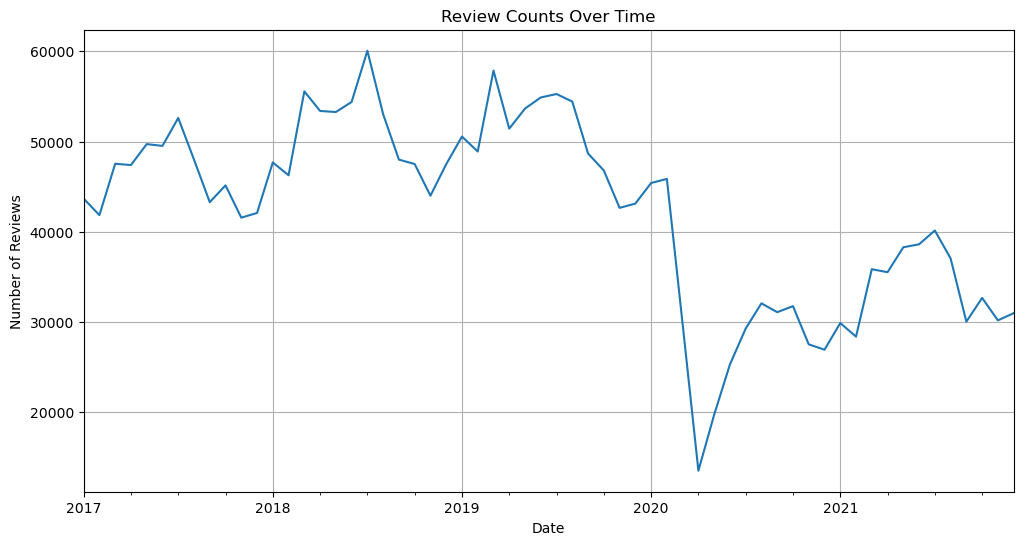

In [20]:
# Plotting reviews over time
user_eda.plot_reviews_over_time()

### Observations

1. **2017-2019 Trends**:
   - The number of reviews generally increased with noticeable seasonal peaks typically between April and July, reflecting periods of higher customer engagement, possibly due to holidays or promotions.

2. **Sharp Decline in 2020**:
   - A dramatic drop in review counts occurred in early 2020, coinciding with the COVID-19 pandemic. The pandemic led to widespread lockdowns and restaurant closures, drastically reducing customer activity and the number of reviews.

3. **Slow Recovery in 2021**:
   - The recovery in review counts during 2021 was slow and inconsistent, not reaching pre-pandemic levels. This gradual rebound may be due to ongoing restrictions, changes in consumer behavior, and the permanent closure of some restaurants.

4. **Implications**:
   - The plot highlights the significant impact of the COVID-19 pandemic on the restaurant industry, with lasting effects that may alter consumer behavior and delay a full return to previous levels of dining activity.


***
## 3.DATA PREPARATION
***

We will clean, and transform diverse data sources, including restaurant attributes, cuisine, and historical interactions. Ensuring data quality and consistency is essential for accurate model training. The prepared dataset forms the foundation for building a robust and personalized recommendation engine."




#### i) User Review Data
***


In [17]:
# Checking the duplicates in the user data
checks= DataChecks(users_data)
checks.check_duplicates()

NO DUPLICATES FOUND


In [18]:
# Dropping the duplicates
users_data_cleaned= users_data.drop_duplicates()

# Confirming the duplicates have been dropped
checks= DataChecks(users_data_cleaned)
checks.check_duplicates()

NO DUPLICATES FOUND


In [19]:
#Checking the first five rows fot the user_data
users_data_cleaned.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,iBUJvIOkToh2ZECVNq5PDg,iAD32p6h32eKDVxsPHSRHA,YB26JvvGS2LgkxEKOObSAw,5,0,0,0,I've been eating at this restaurant for over 5...,2021-01-08 01:49:36
1,HgEofz6qEQqKYPT7YLA34w,rYvWv-Ny16b1lMcw1IP7JQ,jfIwOEXcVRyhZjM4ISOh4g,1,0,0,0,How does a delivery person from here get lost ...,2021-01-02 00:19:00
2,Kxo5d6EOnOE-vERwQf2a1w,2ntnbUia9Bna62W0fqNcxg,S-VD26LE_LeJNx5nASk_pw,5,0,0,0,"The service is always good, the employees are ...",2021-01-26 18:01:45
3,STqHwh6xd05bgS6FoAgRqw,j4qNLF-VNRF2DwBkUENW-w,yE1raqkLX7OZsjmX3qKIKg,5,0,0,0,two words: whipped. feta. \nexplosion of amazi...,2021-01-27 23:28:03
4,u0smrr16uVQ8pgSEseXcKg,H3P9EB7J9HP6PzkVjgFiOg,oQ5CPRt0R3AzFvcjNOqB1w,5,0,0,0,So day 2 in Nashville. I gotta get some BBQ. M...,2021-03-17 20:09:00


In [20]:
# Checking information
users_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429771 entries, 0 to 429770
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_id    429771 non-null  object
 1   user_id      429771 non-null  object
 2   business_id  429771 non-null  object
 3   stars        429771 non-null  int64 
 4   useful       429771 non-null  int64 
 5   funny        429771 non-null  int64 
 6   cool         429771 non-null  int64 
 7   text         429771 non-null  object
 8   date         429771 non-null  object
dtypes: int64(4), object(5)
memory usage: 29.5+ MB


 **Observations**
 ***
 
> The duplicated rows were dropped in preparation for modelling.

> The data has 2,559,584 rows and 4 columns.

#### ii) Restaurant Informational Data
***

In [21]:
# Looking into the first five rows of the data frame
restaurant_data.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': ""u'full_bar'"", '...","Pubs, Restaurants, Italian, Bars, American (Tr...",NaN
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,NaN,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ""'none'"", 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."


In [22]:
# Checking for null values in the dataset
restaurant_data.isna().sum()

business_id        0
name               0
address          443
city               0
state              0
postal_code       21
latitude           0
longitude          0
stars              0
review_count       0
is_open            0
attributes       566
categories         0
hours           7279
dtype: int64

**Observation**
***

The dataset contains null values in the columns: address, postal code, attributes and hours

In [23]:
# Dropping null values
restaurant_data = restaurant_data.dropna(subset=['attributes'])

In [24]:
# Filling missing values in the 'attributes' column with 'Unknown'
restaurant_data[['address','postal_code','hours']]=restaurant_data[['address','postal_code','hours']].fillna('Unknown')

# Verifying that all missing values have been handled
restaurant_data.isnull().sum()


business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
stars           0
review_count    0
is_open         0
attributes      0
categories      0
hours           0
dtype: int64

**Observations**
***
 There were some missing values in the `attributes`, `address`, `postal_code`, and `hours` columns.
 
 We handled the missing data in two ways:
 
 1) **Dropping the records with null values**

- Rows with missing `attributes` were removed as this column is critical for analysis.

2) **Imputation**

- Missing values in `address`, `postal_code`, and `hours` were imputed  with 'Unknown' to maintain data integrity.

In [25]:
# Checking the value counts for the states
restaurant_data.state.value_counts()

state
PA     12538
FL      8632
TN      4297
MO      4219
IN      4119
LA      3596
NJ      3302
AZ      2635
AB      2355
NV      1657
ID      1290
CA      1151
IL       975
DE       949
NC         1
CO         1
HI         1
MT         1
XMS        1
Name: count, dtype: int64

In [26]:
# States labeled `XMS` will be filtered out, as they do not seem valid
valid_states = ['XMS','MT','NC','HI','CO',]
restaurant_data_filtered = restaurant_data[~restaurant_data['state'].isin(valid_states)]


In [27]:
# Map state abbreviations to full state names
state_abbreviations = {
    'AB': 'Alberta', 'AZ': 'Arizona', 'CA': 'California', 'DE': 'Delaware', 'FL': 'Florida', 'ID': 'Idaho','IL': 'Illinois',
    'IN': 'Indiana','LA': 'Louisiana',  'MO': 'Missouri','NV': 'Nevada', 'NJ': 'New Jersey','PA': 'Pennsylvania',  'TN': 'Tennessee', 
}
# Replace state initials with full names
restaurant_data_filtered['state'] = restaurant_data_filtered['state'].map(state_abbreviations)



**Observation**
***

- States labeled XMS,MT,NC,HI and Co were noted in the EDA for having unusually small restaurant counts, upon confirmation, they have been filtered  out as they contain only a value of one restaurant per state therefore not statistically relevant to our project.

- The state abbreviations have been successfully mapped to their corresponding full state names, providing more clarity,simplicity,coherence and consistency in the data.

### FEATURE ENGINEERING
***

We will continue with feature engineering with the following steps
1. Exploding the categories to refine out cuisine list.
2. Elimiating spaces that arise from the splits.
3. Engineering a Location column that is a combination of various features.
4. Filtering the attributes column to keep only attributes that are true.
 

In [28]:
# Exploding the categories column to ensure each category is handled separately
df_exploded = restaurant_data_filtered.assign(categories=restaurant_data_filtered['categories'].str.split(',')).explode('categories')

df_exploded.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,Pennsylvania,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Restaurants,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,Pennsylvania,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Food,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,Pennsylvania,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Bubble Tea,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,Pennsylvania,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Coffee & Tea,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,Pennsylvania,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...",Bakeries,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."


In [29]:
# Function to standardize spacing
def standardize_spacing(x):
    if isinstance(x, str):
        return re.sub(r'\s+', ' ', x.strip())
    return x

# Apply the function to all elements in the DataFrame
df_exploded = df_exploded.applymap(standardize_spacing)

In [30]:
# List of all the Cuisine in the categories
cuisine=["American(New)", "Mexican",'American (Traditional)','Italian','Chinese',
         'Japanese','Asian Fusion','Mediterranean','Southern','Cajun/Creole','Tex-Mex',
         'Thai','Latin American','Indian','Vietnamese','Greek','Caribbean','Middle Eastern',
         'French','Korean','Halal','Spanish','Canadian (New)','Irish','Pakistani','Hawaiian',
         'Soul Food','German','Szechuan','African','Filipino','Lebanese','Puerto Rican','Turkish',
         'Cantonese','British','Peruvian','Kosher','Brazilian','Pan Asian','Taiwanese','Cuban','Colombian',
         'Ethiopian','Venezuelan','Salvadoran','Laotian','Polish','Dominican','Russian','Persian/Iranian',
         'Afghan','Moroccan','Arabic','Portuguese','Mongolian','Argentine','Malaysian','Belgian',
         'Honduran','Himalayan/Nepalese','Armenian','Trinidadian','Ukrainian','Australian','Egyptian']

# Filtering to get restaurants with cuisine
restaurant_exploded = df_exploded[df_exploded.categories.isin(cuisine)]

In [31]:
# Display the 'location' column to check the combined addresses
restaurant_exploded.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,Missouri,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': ""u'full_bar'"", '...",Italian,Unknown
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,Missouri,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': ""u'full_bar'"", '...",American (Traditional),Unknown
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,Missouri,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': ""u'full_bar'"", '...",Greek,Unknown
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,Unknown,Tampa Bay,Florida,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ""'none'"", 'OutdoorSeating': 'None'...",Vietnamese,"{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'..."
5,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,Indiana,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...",American (Traditional),"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."


In [32]:
# combining the address columns into a location column
restaurant_exploded['location']=restaurant_exploded[['city','state','address']]\
            .apply( lambda x: f"State:{x['state']}, City:{x['city']}, Address:{x['address']} ", axis=1)


# viewing the restaurant_exploded dataset information
restaurant_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38528 entries, 2 to 52285
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   38528 non-null  object 
 1   name          38528 non-null  object 
 2   address       38528 non-null  object 
 3   city          38528 non-null  object 
 4   state         38528 non-null  object 
 5   postal_code   38528 non-null  object 
 6   latitude      38528 non-null  float64
 7   longitude     38528 non-null  float64
 8   stars         38528 non-null  float64
 9   review_count  38528 non-null  int64  
 10  is_open       38528 non-null  int64  
 11  attributes    38528 non-null  object 
 12  categories    38528 non-null  object 
 13  hours         38528 non-null  object 
 14  location      38528 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 4.7+ MB


**Observations**
***
 
- The `categories` column have been standardized and exploded to handle multiple categories per restaurant. This transformation is necessary to accurately categorize each restaurant's offerings, which is essential for matching user preferences with the right restaurants.

- The exploded DataFrame has been filtered to include only rows with specified cuisines. By narrowing down to specific cuisines, we ensure that the recommender system focuses on the most relevant restaurant types. This helps in improving precision

- Combining the `state`, `city`, and `address` columns is vital for geographic-based recommendations, enabling the system to suggest restaurants within a user’s preferred or current location.

- This results in a dataset with 38,528 rows of restaurants with their cuisine types and 15 columns

In [33]:
def decompress(x):
    """
    The function takes in a dictionary and returns only the keys that have their values not being False   
    """
      
    list_ = []
    
    # Check if x is a string
    if not isinstance(x, str):
        return ' '
    
    # evaluate the attributes column to convert it from a string to a dictionary
    try:
        data_dict = eval(x)
    except Exception as e:
        print(f"Error evaluating {x}: {str(e)}")
        return ' '
    
    # iterate through the key-value pairs in the dictionary
    for key, val in data_dict.items():
        # check if the key is in the specified categories and if the value is not "None"
        if (key in ['Ambience', 'GoodForMeal', 'BusinessParking']) and (val != "None"):
            # if conditions are met, further iterate through sub-dictionary
            try:
                sub_dict = eval(val)
                for key_, val_ in sub_dict.items():
                    # if the sub-dictionary value is true, append it to the list
                    if val_:
                        list_.append(f'{key}{key}')
            except Exception as e:
                print(f"Error evaluating {val}: {str(e)}")
        else:
            # if the value is not false, append the key to the list
            if val != 'False':
                list_.append(key)
    
    # join the list of selected attribute names into a space-separated string
    return " ".join(list_)

# create a new column 'attributes_true' in the df by applying the decompress function
# include a condition to handle cases where attributes is 'Not-Available'
restaurant_exploded['attributes_true'] = restaurant_exploded.attributes.apply(lambda x: decompress(x) if x != 'Not-Available' else ' ')

In [34]:
# Example to show the new column generated using a sample business_id
# Temporarily set display options
pd.set_option('display.max_colwidth', None)  

# Display the attributes sections
print("Original Attributes Column",restaurant_data[restaurant_data.business_id=='k0hlBqXX-Bt0vf1op7Jr1w'].attributes[:1])
print("Attributes_true Column",restaurant_exploded[restaurant_exploded.business_id=='k0hlBqXX-Bt0vf1op7Jr1w'].attributes_true[:1])

# Reset display options to default after viewing
pd.reset_option('display.max_colwidth')


Original Attributes Column 2    {'Caters': 'True', 'Alcohol': "u'full_bar'", 'RestaurantsAttire': "u'casual'", 'RestaurantsDelivery': 'False', 'RestaurantsTakeOut': 'True', 'HasTV': 'True', 'NoiseLevel': "u'average'", 'BusinessAcceptsCreditCards': 'True', 'OutdoorSeating': 'True', 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", 'Ambience': "{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': False}", 'RestaurantsPriceRange2': '1', 'GoodForKids': 'True', 'WiFi': "u'free'", 'RestaurantsReservations': 'False', 'RestaurantsGoodForGroups': 'True'}
Name: attributes, dtype: object
Attributes_true Column 2    Caters Alcohol RestaurantsAttire RestaurantsTakeOut HasTV NoiseLevel BusinessAcceptsCreditCards OutdoorSeating BusinessParkingBusinessParking RestaurantsPriceRange2 GoodForKids WiFi RestaurantsGoodForGroups
Name: attributes_true, d

In [35]:
# Checking the shape of the dataset
restaurant_exploded.shape

(38528, 16)

**Observations:**
***
- By using the compress function, the attributes column was stripped of any attributes that were False and a new column attributes true was created that only had the true attributes of each restaurant

- This results in a dataset with 38,528 rows of restaurants with their cuisine types and 16 columns

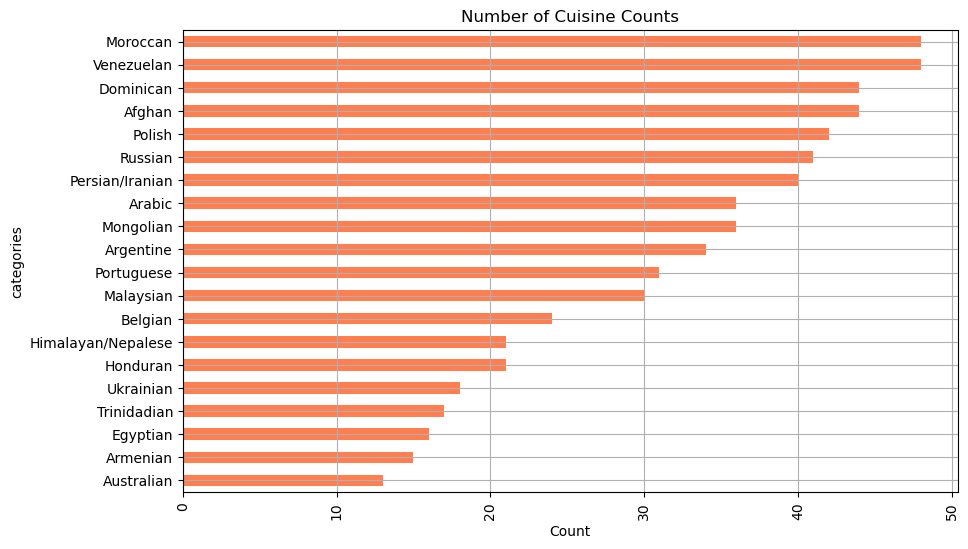

In [36]:
# Instantiate the UnivariateAnalysis class with the DataFrame
uni_analysis = UnivariateAnalysis(restaurant_exploded)
uni_analysis.plot_bar_chart('categories', 'Number of Cuisine Counts', limit=20, horizontal=True, descending=False)

**Observations:**
***

- The majority of the restaurants mainly fall within American(Traditional), Italian, Mexican, Chinese, Japanese
- American(Traditional) was largely dominant in the dataset after splitting


In [40]:
# Save the cleaned user review data to a new CSV file
users_data_cleaned.to_csv('data/cleaned_users_data.csv', index=False)

In [41]:

# Save the filtered and transformed restaurant data to a new CSV file
with open('Pickled_files/restaurants_data.pkl','wb')as file:
    pickle.dump(restaurant_exploded, file)


***
## 4. MODELLING
***

In this section we will create a recommendation system using the datasets to solve our main problem.
There are different types of recomentation models, in this project we will focus on three types of recommentation systems

* 1. Content-Based Recommender systems
* 2. Collaborative Filtering Systems
* 3. Deep Neural Networks

Now, in each of these categories we will compare the different models and see which ones perform best. For validation and comparison we will use the RMSE (root mean squared error) metric, that is how far is the prediction from the true value.

***
##### 1. CONTENT BASED FILTERING
***
To perfrom the content based filtering, we utilized the restaurant data dataset.

The restaurant's features such as types of cuisine they offer and attribues such as WiFi, Alcohol, Happy Hour, Noise Level, Restaurants Attire, Wheelchair Accessible, Restaurants TableService etc, were able to provide information to use cosine similarity to recommend the restaurants with the closest similarity.

In [42]:
# Loading the restaurant data from the pickled file
df = pd.read_pickle('pickled_files/restaurants_data.pkl')

# Overview of dataset information to understand the features we require
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38528 entries, 2 to 52285
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   business_id      38528 non-null  object 
 1   name             38528 non-null  object 
 2   address          38528 non-null  object 
 3   city             38528 non-null  object 
 4   state            38528 non-null  object 
 5   postal_code      38528 non-null  object 
 6   latitude         38528 non-null  float64
 7   longitude        38528 non-null  float64
 8   stars            38528 non-null  float64
 9   review_count     38528 non-null  int64  
 10  is_open          38528 non-null  int64  
 11  attributes       38528 non-null  object 
 12  categories       38528 non-null  object 
 13  hours            38528 non-null  object 
 14  location         38528 non-null  object 
 15  attributes_true  38528 non-null  object 
dtypes: float64(3), int64(2), object(11)
memory usage: 5.0+ MB


In [43]:
# Preprocessing function
def preprocess(df):
    """
    Function to preprocess the data to combine the needed features into one column
    Returns a dataframe with the combined_features columns
    """
    filtered_df=df.copy()
    # Combining the features into one column
    filtered_df['combined_features'] = (
                                        filtered_df['categories'] + " " +
                                        filtered_df['attributes_true'] 
                                        )
    # resetting the index
    filtered_df = filtered_df.reset_index(drop=True)

    # Return turns the filtered df
    return filtered_df

In [44]:
# Vectorization function
def create_feature_vectors(df):
    """
    Performing vectorization of the preprocessed categorical features 
    and combining with the numerical features
    """
    # Vectorize the combined text features
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['combined_features'])
    
    # Combine the TF-IDF matrix with numerical columns
    numerical_features = df[['stars']].values
    combined_features = np.hstack((tfidf_matrix.toarray(), numerical_features))
    
    return combined_features


Using the cosine similarity matrix we will now create a content-based recommendation system that offers recommendations to users based on the restaurant names or text words representing the specifications of their desired restaurant and attributes.

We use the cosine similarity matrix to compare similarities between different restaurants and the customer's preferences, then pick the top n similar restaurants to recommend based on his/her input.

In [45]:
# Recommendation function
def recommendation(df, state, name=None, category=None):
    """
    Creates recommendation based on name or category/cuisine using cosine similarity and filtering
    Returns a dataframe containing name, state, city, address, stars and categories
    """
    preprocessed = preprocess(df)
    
    def cuisines(cuisine=None, state=state):
        """
        Function to filter to get the recommendations based on cuisine input
        """
        preprocessed=df[df["state"]==state]
        cuisine_df = preprocessed[preprocessed['categories'] == cuisine]
        cuisine_df_sorted = cuisine_df.sort_values(by=["stars", "city"], ascending=False)
        return cuisine_df_sorted[['name', 'state', 'city', 'stars', 'address', 'categories']]
    
    if name:
        if name not in preprocessed['name'].values:
            raise ValueError(f"Restaurant with name '{name}' not found in the filtered data.")

        # Finding the index of the restaurant name
        idx = preprocessed[preprocessed['name'] == name].index[0]
        exclude_names = [name]

        # Locating the restaurant row in the preprocessed df 
        row_to_add = preprocessed.iloc[idx]
        
        # convering it to a df
        row_to_add_df = pd.DataFrame([row_to_add])     
        
        #generating a df for only the state i want to recommend in
        specific_state= preprocessed[preprocessed["state"] == state]
        
        # concatinating it to the specific state df and reseting the index
        specific_state = pd.concat([specific_state, row_to_add_df]).reset_index(drop=True)
        
        # Finding the new index for the restaurant name
        idx = specific_state[specific_state['name'] == name].index[0]
        
        # Creating feature vectors
        combined_features = create_feature_vectors(specific_state)

        # Finding the cosine similarity
        cosine_sim = cosine_similarity(combined_features, combined_features)

        # Finding the top indices of the restaurants to recommend
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_indices = [i[0] for i in sim_scores]  

        # Finding the rows of the top recommended restaurants
        recommended_restaurants = specific_state.iloc[top_indices]
        recommended_restaurants = recommended_restaurants[~recommended_restaurants['name'].isin(exclude_names)]        

        # Return a df with the required features
        return recommended_restaurants[['name', 'state', 'city', 'stars', 'address','categories']].drop_duplicates(subset='name')[:20]
    
    elif category:
        # Filter based on cuisine/cateogry
        return cuisines(category)

The content_based function uses content-based recommendation techniques to provide restaurant recommendations based on user input preferences, restaurant names, or cuisine choice. 

In [46]:
# Getting a random restaurant name
random_name = df['name'].sample(n=1).values[0]
print("Random Restaurant Name:", random_name)

# Information on sampled restaurant
df[df.name==random_name]

Random Restaurant Name: Sacred Pepper


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,location,attributes_true
15810,j4KA-BujEH7xmG6bD5E-gQ,Sacred Pepper,15405 N Dale Mabry Hwy,Tampa,Florida,33618,28.092106,-82.501806,4.0,548,1,"{'RestaurantsReservations': 'True', 'GoodForKi...",American (Traditional),"{'Monday': '16:0-22:0', 'Tuesday': '16:0-22:0'...","State:Florida, City:Tampa, Address:15405 N Dal...",RestaurantsReservations Caters BusinessAccepts...


In [47]:
# Randomly chosen state
random_state = df['state'].sample(n=1).values[0]
print("Random State:", random_state)

# recommendations based on random state and random restaurant name
restaurants = recommendation(df, state=random_state,  name=random_name)
restaurants.head(10)

Random State: Arizona


,name,state,city,stars,address,categories
1191,Snooze An AM Eatery,Arizona,Tucson,4.5,"2500 E Grant Rd, Ste 182",American (Traditional)
1679,Gentle Ben’s Brewery,Arizona,Tucson,3.5,865 E University Blvd,American (Traditional)
1074,Agave,Arizona,Sahuarita,3.5,1100 W Pima Mine Rd,American (Traditional)
1190,CORE Kitchen & Wine Bar,Arizona,Marana,4.5,"15000 North Secret Springs Dr, The Ritz-Carlto...",American (Traditional)
614,Holy Smokin Butts BBQ,Arizona,Tucson,4.5,6940 E Broadway Blvd,American (Traditional)
1202,Sunny Daze Cafe,Arizona,Tucson,4.5,4980 S Campbell Ave,American (Traditional)
1632,Lindy's On 4th,Arizona,Tucson,4.0,500 N 4th Ave,American (Traditional)
1020,Cafe Santa Rosa,Arizona,Tucson,4.0,2615 S 6th Ave,American (Traditional)
219,First Watch,Arizona,Tucson,4.5,4775 E Grant Rd,American (Traditional)
541,The Fix,Arizona,Tucson,4.0,"943 E University Blvd, Ste 115",American (Traditional)


In [48]:
# Randomly chosen state
random_state = df['state'].sample(n=1).values[0]
print("Random State:", random_state)

# recommendations based on random state and random restaurant name
restaurants = recommendation(df, state=random_state,  name=random_name)
restaurants.head(10)

Random State: Florida


,name,state,city,stars,address,categories
5013,Grillsmith - Midtown South Tampa,Florida,Tampa,4.5,612 N Dale Mabry Hwy,American (Traditional)
5827,Marina Cantina,Florida,Clearwater Beach,4.0,25 Causeway Blvd,American (Traditional)
4418,The Queenshead Eurobar,Florida,Saint Petersburg,4.0,2501 Central Ave,American (Traditional)
2164,Grillsmith - Countryside,Florida,Clearwater,4.0,"2539 Countryside Blvd, Ste 6",American (Traditional)
2467,Isabelle's Restaurant Gulfport,Florida,Gulfport,4.0,2937 Beach Blvd,American (Traditional)
5062,Mother's,Florida,Tampa,4.0,12227 W Linebaugh Ave,American (Traditional)
5385,Grille One Sixteen,Florida,Tampa,4.0,15405 N Dale Mabry,American (Traditional)
6388,Sea Hags Bar and Grill,Florida,St. Pete Beach,4.0,9555 Blind Pass Rd,American (Traditional)
6391,Tampa Bay Brewing Company,Florida,Tampa,4.0,1600 E 8th Ave,American (Traditional)
5981,Shelly's Cafe,Florida,Tampa,4.5,14837 N Florida Ave,American (Traditional)


**Observations**
***

- A randomly sampled restaurant name and a randomly sampled state were chosen for demostrational purposes.
- It can be noted that, recommendation locations are accurate in that the restaurant may not be from that state but recommendations are given for the state in question.
- We can also see that majority of the cuisines/categories match the restaurant in question.
- Other attributes_true features contribute to the recommendations


In [49]:
random_state = df['state'].sample(n=1).values[0]
print("Random State:", random_state)

random_cuisine = df['categories'].sample(n=1).values[0]
print("Random Cuisine:", random_cuisine)

# Example recommendations based on state, category/cuisine
cuisines = recommendation(df, state=random_state,  category=random_cuisine)
cuisines.head()

Random State: Pennsylvania
Random Cuisine: Italian


,name,state,city,stars,address,categories
11527,Tredici,Pennsylvania,Wayne,5.0,185 E Lancaster Ave,Italian
44819,Napoletano Brothers,Pennsylvania,Springfield,5.0,186 Saxer Ave,Italian
3922,Lucatelli's,Pennsylvania,Philadelphia,5.0,1709 Chestnut St,Italian
5271,Mediterranean Banquet Hall,Pennsylvania,Philadelphia,5.0,2033 S Bancroft St,Italian
5588,Fiorella's Sausage,Pennsylvania,Philadelphia,5.0,817 Christian St,Italian


**Observations**
***
- A randomly sampled state and a randomly sampled cuisine was used for demostration puposes
- It can be seen that the system recommends the cuisine desired 
- As well as recommending specifically in the state desired.

***
##### 2. COLLABORATIVE FILTERING MODELS
***

Here the tasks related to building a collaborative filtering recommendation system using the Surprise library are undertaken for collaborative filtering by selecting the relevant columns, importing the Surprise library, initializing a Reader object to specify the data format, and then loading the data into a Surprise Dataset object for further analysis and model building.

In [50]:
# Loading the users csv file
users_data= pd.read_csv("data/cleaned_users_data.csv")

# summary information on data
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2559584 entries, 0 to 2559583
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   business_id  object
 2   stars        int64 
 3   date         object
dtypes: int64(1), object(3)
memory usage: 78.1+ MB


In [51]:
# merging the two datasets into one using the business_id primary key
data=pd.merge(left=users_data, right=df, how='inner', on='business_id')

# previewing the new merge dataset
data.head()

,user_id,business_id,stars_x,date,name,address,city,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours,location,attributes_true
0,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,2017-01-14 20:54:15,Melt,2549 Banks St,New Orleans,Louisiana,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': ""{'garage': False, 'street...",American (Traditional),"{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '...","State:Louisiana, City:New Orleans, Address:254...",BusinessParkingBusinessParking GoodForMealGood...
1,RreNy--tOmXMl1en0wiBOg,cPepkJeRMtHapc_b2Oe_dw,4,2018-07-17 03:30:07,Naked Tchopstix Express,"2902 W 86th St, Ste 70",Indianapolis,Indiana,46268,39.912505,-86.211285,3.5,33,0,"{'GoodForMeal': ""{'dessert': False, 'latenight...",Hawaiian,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...","State:Indiana, City:Indianapolis, Address:2902...",OutdoorSeating RestaurantsTakeOut RestaurantsG...
2,Jha0USGDMefGFRLik_xFQg,bMratNjTG5ZFEA6hVyr-xQ,5,2017-02-19 13:32:05,Portobello Cafe,1423 Chester Pike,Eddystone,Pennsylvania,19022,39.865032,-75.344051,4.0,137,1,"{'BikeParking': 'True', 'RestaurantsReservatio...",Italian,"{'Monday': '16:30-21:0', 'Tuesday': '16:30-21:...","State:Pennsylvania, City:Eddystone, Address:14...",BikeParking RestaurantsReservations HasTV Rest...
3,iYY5Ii1LGpZCpXFkHlMefw,Zx7n8mdt8OzLRXVzolXNhQ,5,2018-04-27 23:03:21,Milk and Honey Nashville,214 11th Ave S,Nashville,Tennessee,37203,36.154702,-86.784541,4.0,1725,1,"{'WheelchairAccessible': 'True', 'RestaurantsP...",American (Traditional),"{'Monday': '0:0-0:0', 'Thursday': '6:30-15:0',...","State:Tennessee, City:Nashville, Address:214 1...",WheelchairAccessible RestaurantsPriceRange2 Bu...
4,S7bjj-L07JuRr-tpX1UZLw,I6L0Zxi5Ww0zEWSAVgngeQ,4,2018-07-07 20:50:12,Cafe Beignet on Bourbon Street,311 Bourbon St,New Orleans,Louisiana,70130,29.955845,-90.068436,3.5,1066,1,"{'GoodForKids': 'True', 'OutdoorSeating': 'Tru...",Cajun/Creole,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-15:0', '...","State:Louisiana, City:New Orleans, Address:311...",GoodForKids OutdoorSeating BusinessAcceptsCred...


In [52]:
# Renaming the **stars_x** and **stars_y** columns into **rating** and **b/s_rating** columns for better understanding
data.rename(columns={'stars_x':'b/s_rating', 'stars_y':'rating'}, inplace=True)

# previewing the data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386717 entries, 0 to 2386716
Data columns (total 19 columns):
 #   Column           Dtype  
---  ------           -----  
 0   user_id          object 
 1   business_id      object 
 2   b/s_rating       int64  
 3   date             object 
 4   name             object 
 5   address          object 
 6   city             object 
 7   state            object 
 8   postal_code      object 
 9   latitude         float64
 10  longitude        float64
 11  rating           float64
 12  review_count     int64  
 13  is_open          int64  
 14  attributes       object 
 15  categories       object 
 16  hours            object 
 17  location         object 
 18  attributes_true  object 
dtypes: float64(3), int64(3), object(13)
memory usage: 346.0+ MB


#### **Preprocessing Data For Modeling**
***

In [53]:

#selecting specific columns that are relevant for collaborative filtering models
new_df = data[['user_id', 'business_id', 'rating']]

# using Reader() from surprise module to convert dataframe into surprise dataformat
# instantiating a reader object
reader = Reader(rating_scale=(1, 5))

# using the reader to read the trainset
data_2 = Dataset.load_from_df(new_df,reader)

# Creating a train set with all available data
dataset = data_2.build_full_trainset()

# Split the data into training and test sets
trainset, testset = train_test_split(data_2, test_size=0.25)

print('Number of users: ', dataset.n_users, '\n')
print('Number of Restaurants: ', dataset.n_items)

Number of users:  738495 

Number of Restaurants:  24835


In [54]:
# saving the data as a pickle

with open('pickled_files/new_df.pkl','wb') as file:
    pickle.dump(new_df, file)


### **Baseline Model Using Normal Predictor**
***

In [55]:
# Initialize the Normal Predictor algorithm
model_1 = NormalPredictor()

# Train the model on the training set
model_1.fit(trainset)

# Predict ratings for the test set
predictions = model_1.test(testset)

# Compute rmse
accuracy.rmse(predictions)

RMSE: 0.8201


0.8200931132756992

**Observations:**
***
- A normal predictor model from the surpise library was used as the initial dummy prediction model
- The model was able to achieve an RMSE of 0.82

### **NMF Model With Default Parameters**
***

In [56]:
# Initialize the NMF algorithm
model_2 = NMF(random_state=42)

# Train the model on the training set
model_2.fit(trainset)

# Predict ratings for the test set
predictions = model_2.test(testset)

# Compute RMSE
accuracy.rmse(predictions)

RMSE: 0.3479


0.3479329268051897

**Observations:**
***
- A Non-Negative Matrix Factorization(NMF) model was used as it is ideal when ratings are non-negative (i.e., ratings from 1 to 5).
- The model was able to achieve an RMSE of 0.3479 which was a great improvement on the Normal Predictor.

### **SVD Model With Default Parameters**
***

In [57]:
# Initialize the SVD algorithm
model_3 = SVD(random_state=42)

# Train the model on the training set
model_3.fit(trainset)

# Predict ratings for the test set
predictions = model_3.test(testset)

# Compute RMSE
accuracy.rmse(predictions)

RMSE: 0.1194


0.11941745799157445

In [58]:
# using cross-validate to get the test rmse scores for 5 splits
results=cross_validate(model_3, data_2, cv=5, n_jobs=-1)


for values in results.items():
    print(values)
print("-------------------------")
print("Mean RMSE: ",results['test_rmse'].mean())

('test_rmse', array([0.11388697, 0.11385811, 0.11401238, 0.11271292, 0.11303187]))
('test_mae', array([0.05426671, 0.0543461 , 0.05436113, 0.05420301, 0.05429241]))
('fit_time', (47.15068030357361, 53.74115061759949, 55.80449366569519, 52.29677605628967, 44.35997986793518))
('test_time', (12.15089750289917, 10.390844583511353, 7.597814083099365, 6.631013870239258, 5.19765830039978))
-------------------------
Mean RMSE:  0.11350045092946788


**Observations:**
***
- A Singe value Decomposition(SVD) model was used as it works well with explicit feedback (i.e. ratings)
- The model was able to achieve an RMSE of 0.119 which further improved the RMSE
- The model was then cross validated and ahcieved an RMSE mean of 0.113

## 

### **Hyperparameter Tuning SVD model**
***
Hyperparameter tuning was carried out using grid search and cross-validation. It tests different values of the number of latent factors (n_factors),regularization term (reg_all) and the number of epochs (n_epochs) to find the combination that results in the best model performance. The final best hyperparameters can be accessed from the g_s_svd object for use in the model.

In [59]:
# define a dictionary params with hyperparameter values to be tested
params = {'n_factors': [20, 50, 100], 
         'reg_all': [00.01, .02, 0.05],
         'n_epochs':[20,30,40]} 

# create a GridSearchCV object 'g_s_svd' for hyperparameter tuning
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1) 

# fit the GridSearchCV object to the data to find the best hyperparameters
g_s_svd.fit(data_2)

In [60]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.06590769803519636, 'mae': 0.02687237883365128}
{'rmse': {'n_factors': 20, 'reg_all': 0.01, 'n_epochs': 40}, 'mae': {'n_factors': 20, 'reg_all': 0.01, 'n_epochs': 40}}


In [74]:
# Fitting optimal parameters

# Initialize the SVD algorithm
model_4 = SVD(n_factors= 20, reg_all=0.01, n_epochs = 40,random_state=0)

# Train the model on the training set
model_4.fit(trainset)

# Predict ratings for the test set
predictions = model_4.test(testset)

# Compute RMSE
accuracy.rmse(predictions)

RMSE: 0.0709


0.07088918487239984

In [67]:
# using cross-validate to get the test rmse scores for 5 splits
results=cross_validate(model_4, data_2, cv=5, n_jobs=-1)


for values in results.items():
    print(values)
print("-------------------------")
print("Mean RMSE: ",results['test_rmse'].mean())

('test_rmse', array([0.06513394, 0.06643733, 0.06514964, 0.06658183, 0.06595623]))
('test_mae', array([0.02672965, 0.02699132, 0.02680206, 0.02702771, 0.02696134]))
('fit_time', (43.560943603515625, 50.73513913154602, 49.578089475631714, 42.3820915222168, 33.8181517124176))
('test_time', (11.722263813018799, 7.895150661468506, 6.520659685134888, 5.259667158126831, 4.641919851303101))
-------------------------
Mean RMSE:  0.06585179559945789


In [62]:
# Saving the model into a pickle
with open('pickled_files/svd.pkl', 'wb') as file:
    pickle.dump(model_4, file)

**Observations:**
***

The RMSE value for the optimized SVD model is approximately 0.07, indicating the model's average prediction error in terms of user ratings. Lower RMSE values are desirable as they signify better predictive accuracy.                              
                                           
The best-performing hyperparameter values are as follows:                       
For optimal RMSE, the optimal hyperparameters are 'n_factors' = 20,'reg_all' = 0.01 and 'n_epochs': 40.
  
These results indicate that the SVD collaborative filtering model, when configured with these hyperparameters, provides a relatively low prediction error and is well-suited for making personalized recommendations based on user ratings.

This model was then saved in a pickle file for deployment

**Collaborative filtering Intergration**
***


This below  allows a user to interactively rate restaurants by providing their ratings for a specified number of restaurants, and it collects this information in a list for further analysis or use in a recommendation system. The code also considers the restaurant category for selecting restaurants to rate if a category is provided.

In [63]:
def collect_ratings(df, state, num_samples=5, max_ratings=3):
    """
    Function to collect ratings for a number of randomly sampled restaurants.
    Allows users to skip restaurants they have never been to and limits the total number of final ratings to a specified maximum.
    """
    ratings = []

    while len(ratings) < max_ratings:
        # Sampling the specified number of restaurants
        filtered_df=df[df.state==state]

        sampled_restaurants = filtered_df.sample(n=num_samples)
        
        for _, row in sampled_restaurants.iterrows():
            restaurant_id = row['business_id']
            restaurant_name = row['name']
            restaurant_state=row["state"]
            restaurant_city =row["city"]

            while True:
                # Ask if the user has been to the restaurant
                been_to_restaurant = input(f"Have you been to {restaurant_name}, {restaurant_state},{restaurant_city}? (y/n): ").strip().lower()
                
                if been_to_restaurant == 'n':
                    print(f"Skipping {restaurant_name}.")
                    break  
                
                elif been_to_restaurant == 'y':
                    while True:
                        try:
                            # Prompt user for rating
                            print(f"Please rate {restaurant_name} on a scale of 1 to 5:")
                            rating = int(input())
                            
                            # Check if the rating is within the valid range
                            if 1 <= rating <= 5:
                                print(f"Rating for {restaurant_name}: {rating}")
                                ratings.append((restaurant_id, rating))
                                
                                # Check if we have reached the maximum number of ratings
                                if len(ratings) >= max_ratings:
                                    print("Maximum number of ratings collected.")
                                    return ratings
                                
                                break  
                            else:
                                print("Rating must be between 1 and 5. Please try again.")
                        except ValueError:
                            print("Invalid input. Please enter a number between 1 and 5.")
                    break  
                
                else:
                    print("Please answer 'yes' or 'no'.")
                
        # If not enough ratings are collected, continue sampling
        print(f"Collected {len(ratings)} ratings so far. Collecting more samples.")

    return ratings


In [64]:
def recommend_restaurants(user_id, rated_restaurants, all_restaurants_df=df, state=None):

    """
    Function to recommend restaurants based on state. the rated restaurnats are concatenated to the new_df dataframe, a model is created
    the rated restaurants are filtered from the unrated restaurants and prediction is performed. the resulting dataframe is sorted by highest 
    predicted ratings 
    """
    # Filter by state if provided
    all_restaurants_df = all_restaurants_df[all_restaurants_df["state"] == state]

    # Get all restaurant IDs
    all_restaurant_ids = all_restaurants_df['business_id'].unique()

    # Prepare the data for training the model
    # Create DataFrame for the user's ratings
    user_ratings_df = pd.DataFrame(rated_restaurants, columns=['business_id', 'rating'])
    user_ratings_df['user_id'] = user_id  

    # Combine user-specific ratings with the full dataset
    combined_df = pd.concat([new_df, user_ratings_df])

    # Filter combined_df to include only relevant restaurants
    filtered_df = combined_df[combined_df['business_id'].isin(all_restaurant_ids)]

    # Define the Reader and Dataset
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(filtered_df[['user_id', 'business_id', 'rating']], reader)

    # trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
    trainset = data.build_full_trainset()

    # Retrain the model
    model_4 = SVD(n_factors= 20, reg_all=0.01, n_epochs = 40, random_state=42)
    model_4.fit(trainset)

    # Filter out the restaurants that the user has already rated
    rated_restaurant_ids = [rid for rid, _ in rated_restaurants]
    unrated_restaurants = [rid for rid in all_restaurant_ids if rid not in rated_restaurant_ids]

    # Predict ratings for all unrated restaurants
    predictions = [model_4.predict(user_id, rid) for rid in unrated_restaurants]

    # Create a DataFrame for the predictions
    pred_df = pd.DataFrame({
        'business_id': [pred.iid for pred in predictions],
        'predicted_rating': [pred.est for pred in predictions]
    })

    # Merge with the original restaurants DataFrame to get more information
    recommendations = pred_df.merge(all_restaurants_df, on='business_id', how='left')

    # Sort by predicted rating and get top recommendations
    recommendations = recommendations.sort_values(by='predicted_rating', ascending=False)

    return recommendations

In [65]:
# Collect ratings from the user
print("You will be asked to rate 5 random restaurants.")
user_ratings = collect_ratings(df, state="Pennsylvania")
print(user_ratings)



You will be asked to rate 5 random restaurants.
Please rate Venuto's Old World Pizza on a scale of 1 to 5:
Rating for Venuto's Old World Pizza: 5
Please rate Eve's Lunch on a scale of 1 to 5:
Rating for Eve's Lunch: 3
Please rate Aksum Cafe on a scale of 1 to 5:
Rating for Aksum Cafe: 4
Maximum number of ratings collected.
[('F1hbIYD1lNzbprtckd7bVg', 5), ('YZ0YVMdWUik8ukQp1CILtg', 3), ('XIKYdKWq72zUYsq8NBxcCQ', 4)]


In [66]:
# Entering user_id
user_id = 'uu1651'

# Recommendation based on state and ratings
recommended_restaurants = recommend_restaurants(user_id=user_id, rated_restaurants=user_ratings, state= "Pennsylvania").drop_duplicates(subset='name')

# Viewing the top 5 entries
recommended_restaurants.head()


,business_id,predicted_rating,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,location,attributes_true
8597,trH0bWrq9kwLoLHbvlPKmw,5.0,Villekebabs and Platters,1722 Sansom St,Philadelphia,Pennsylvania,19103,39.950574,-75.169746,5.0,21,1,"{'RestaurantsTableService': 'True', 'Restauran...",Afghan,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...","State:Pennsylvania, City:Philadelphia, Address...",RestaurantsTableService RestaurantsDelivery Re...
1100,5css9Tl6TwMVe8GDLorJkQ,5.0,Maliwan,1700 S 6th St,Philadelphia,Pennsylvania,19148,39.927479,-75.155713,5.0,28,0,"{'Ambience': ""{'touristy': False, 'hipster': F...",Laotian,Unknown,"State:Pennsylvania, City:Philadelphia, Address...",BusinessAcceptsCreditCards HasTV RestaurantsDe...
1086,UnAvkWNib0F3lHtMwikt8Q,5.0,Poke It Up,160 N Gulph Rd,King of Prussia,Pennsylvania,19406,40.087884,-75.393308,5.0,49,1,"{'WiFi': ""u'free'"", 'BusinessParking': ""{'gara...",Hawaiian,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...","State:Pennsylvania, City:King of Prussia, Addr...",WiFi OutdoorSeating BikeParking Caters Wheelch...
6301,tUcZMaE2XPp6qJK5dbZlpg,5.0,El Molino Tortilleria and Restaurant,1739 W Ritner St,Philadelphia,Pennsylvania,19145,39.921592,-75.176768,5.0,20,1,"{'RestaurantsTakeOut': 'True', 'BusinessAccept...",Mexican,"{'Monday': '0:0-0:0', 'Tuesday': '13:0-21:0', ...","State:Pennsylvania, City:Philadelphia, Address...",RestaurantsTakeOut RestaurantsTableService Res...
1606,8OxOLZdINv7OtcZDDAsRCA,5.0,El Volcan cocina mexicana,2851 Ridge Pike,Eagleville,Pennsylvania,19403,40.150128,-75.397194,5.0,25,1,"{'RestaurantsDelivery': 'True', 'BikeParking':...",Mexican,"{'Monday': '0:0-0:0', 'Tuesday': '10:30-21:0',...","State:Pennsylvania, City:Eagleville, Address:2...",RestaurantsDelivery BikeParking BusinessAccept...


**Observations:**
***


For the implementaion of collaborative filtering to be effective, it is highly dependent on the state from which you would choose to rate th restaurants. This is shown using the example above

If you are from Pennsylvania state, Philadelphia city, you would receive rating requests for the state of Pennsylvania. It is possible to skip to only rate restaurants in Philadelphia city only.

The user would have to rate at least 3 restaurants to be able to get recommendations

These ratings would then be passed through an SVD model to predict all the unrated restaurants giving a predicted rating

This predicted rating is then sorted in descending order and used to give a list of all recommendations

***
##### 3. NEURAL NETWORKS MODEL
***

We will run a Keras deep neural network to implement a recommendation system and try to improve our RMSE scores by using neural networks.

> We are going to encode the user_id and business_id features into numeric integers in preparation for the deep learning model.

In [37]:
# Encoding the user_id column
user_encoder = LabelEncoder()                                    # instantiating the encoder
data['userId'] = user_encoder.fit_transform(data.user_id.values) # fitting and transforming the encoder to our column
n_users=data['userId'].nunique()                                 # assigning the number of users to n_user vaiable
print("Number of Users: ",n_users)

# Encoding the business_id column
item_encoder = LabelEncoder()                                          # instantiating the encoder
data['restId'] = user_encoder.fit_transform(data.business_id.values)   # fitting and transforming the encoder to our column
n_rests = data['restId'].nunique()                                  # assigning the number of restaurants to n_rests vaiable
print("Number of Restaurants: ",n_rests)

Number of Users:  220872
Number of Restaurants:  31834


> Splitting the data into training and testing sets for model evaluation.

In [38]:
# subsetting the x variable
X = data[['userId', 'restId']].values
# subsetting the y variable
y = data['rating'].values

# creating the train test splits and stratifying on basis of the y values 
# because of the uneven nature of the rating counts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(428157, 2) (428157,)
(107040, 2) (107040,)


> Calculate the minimum and maximum ratings, which will be used to scale the output of the neural network later.

In [39]:
# Find the minimum and maximum rating
min_rating = min(data['rating'])
max_rating = max(data['rating'])

> The predicted ratings is calculated by multiplying the user and restaurant embeddings, then adding the user and restaurant bias. Therefore were are going to create user and restaurant embeddings together with bias.

In [40]:
# Number of latent factors
embedding_size = 50

> Defining user embedding

In [41]:
# User embeddings

# user input layer
user = layers.Input(shape=(1,))

# Embedding layer for calculating user latent factors of size 50
user_emb = layers.Embedding(n_users, embedding_size, embeddings_regularizer=regularizers.l2(1e-6))(user)

# Reshaping the layer to flatten the embedding vector.
user_emb = layers.Reshape((embedding_size,))(user_emb)

> Defining user bias, and reshape it.

In [42]:
# User bias

# Embedding layer
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)

# Reshapin the user bias layer
user_bias = layers.Reshape((1,))(user_bias)

> Defining restaurants embeddings

In [43]:
# restaurant embeddings

# Input layer
restaurant= layers.Input(shape=(1,))

# Embedding layer
rest_emb = layers.Embedding(n_rests, embedding_size, embeddings_regularizer=regularizers.l2(1e-6))(restaurant)

# Reshape layer
rest_emb = layers.Reshape((embedding_size,))(rest_emb)

> Defining restaurant bias, and reshape it.

In [44]:
# Restaurant bias

# Embedding layer
rest_bias = layers.Embedding(n_rests, 1, embeddings_regularizer=regularizers.l2(1e-6))(restaurant)

# Reshape layer
rest_bias = layers.Reshape((1,))(rest_bias)

> After defining the embedding and bias layers, the predicted rating is calculated by dot product of the user and restaurant embeddings and then adding the bias values in order to get more accurate ratings.

In [45]:
# Dot product of the user and restaurant embeddings
rating = layers.Concatenate()([user_emb, rest_emb])

# Add biases to the ratings
# Adding the user and restaurant bias to the predicted rating
rating = layers.Add()([rating, user_bias, rest_bias])

> We move on to pass the calculated rating to layers of dense networks and finally converting the rating score from binary values into a range of 1-5. 

We create our baseline model.

In [48]:

# first dense layer of 30 nodes with relu activation
rating = layers.Dense(30, activation='relu')(rating)

# second dense layer of 15 nodes
rating = layers.Dense(15, activation='relu')(rating)

# output layer with one node that produces values between 0 and 1 due to the sigmoid activation
rating = layers.Dense(1, activation='sigmoid')(rating)
# rating= layers.Dense(5, activation='softmax')(rating)

# Scales the predicted ratings to a range of 1 - 5
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)


# Baseline Model 
baseline_model = models.Model([user, restaurant], rating)

# Compile the model
baseline_model.compile( optimizer='sgd', loss='mse',  metrics=[metrics.RootMeanSquaredError()])

# training the model
baseline_model .fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
                    batch_size=256, 
                    epochs=10, 
                    verbose=1,
                    validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 246s 146ms/step - loss: 2.2653 - root_mean_squared_error: 1.5015 - val_loss: 2.2630 - val_root_mean_squared_error: 1.5007
Epoch 2/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 248s 148ms/step - loss: 2.2557 - root_mean_squared_error: 1.4983 - val_loss: 2.2616 - val_root_mean_squared_error: 1.5003
Epoch 3/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 245s 138ms/step - loss: 2.2602 - root_mean_squared_error: 1.4998 - val_loss: 2.2623 - val_root_mean_squared_error: 1.5005
Epoch 4/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 341s 185ms/step - loss: 2.2639 - root_mean_squared_error: 1.5011 - val_loss: 2.2614 - val_root_mean_squared_error: 1.5002
Epoch 5/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 275s 157ms/step - loss: 2.2591 - root_mean_squared_error: 1.4994 - val_loss: 2.2607 - val_root_mean_squared_error: 1.5000
Epoch 6/10
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 306s 147ms/step - loss: 2.2514 - root_mean_squared_error: 1.4969 - val_loss: 2.2590 - val_root_mean_squared_error: 1.4994
Epoch 7/10
1673/

> Our baseline model, does not overfit since the training RMSE score and the validation scores are not far off. We then proceed to tune the model in order to get better rmse scores, by reducing the model complexity.

In [50]:

rating = layers.Concatenate()([user_emb, rest_emb])
rating = layers.Add()([rating, user_bias, rest_bias])

# redusing the first dense layer into 15 neurons and adding a l2 regularization
rating = layers.Dense(15, activation='relu',kernel_regularizer=regularizers.l2(1e-3))(rating)
# creating a dropout layer
rating = layers.Dropout(0.3)(rating)
# output layer
rating = layers.Dense(1, activation='sigmoid')(rating)
#convertion of output rating
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

model_1 = models.Model([user, restaurant], rating)

# Compile the model
model_1.compile( optimizer='sgd', loss='mse',  metrics=[metrics.RootMeanSquaredError()])

# Train the model
model_1.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
            batch_size=256,
            epochs=20, 
            verbose=1,
            validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 313s 184ms/step - loss: 2.1169 - root_mean_squared_error: 1.4413 - val_loss: 2.0627 - val_root_mean_squared_error: 1.4232
Epoch 2/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 256s 153ms/step - loss: 1.8676 - root_mean_squared_error: 1.3530 - val_loss: 2.0022 - val_root_mean_squared_error: 1.4022
Epoch 3/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 321s 188ms/step - loss: 1.7143 - root_mean_squared_error: 1.2955 - val_loss: 1.9576 - val_root_mean_squared_error: 1.3865
Epoch 4/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 308s 180ms/step - loss: 1.5578 - root_mean_squared_error: 1.2340 - val_loss: 1.9376 - val_root_mean_squared_error: 1.3795
Epoch 5/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 224s 134ms/step - loss: 1.4274 - root_mean_squared_error: 1.1802 - val_loss: 1.9344 - val_root_mean_squared_error: 1.3785
Epoch 6/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 237s 119ms/step - loss: 1.3002 - root_mean_squared_error: 1.1252 - val_loss: 1.9345 - val_root_mean_squared_error: 1.3787
Epoch 7/20
1673/

> The second model has performed worse than the first with a higher rmse score and the model is overfitting the training data i.e it has a good train score but poor validation score.

we will try and simplify the model further. 

In [51]:

rating = layers.Concatenate()([user_emb, rest_emb])
# Adds the user and restaurant embedding to the dot product of the embeddings
rating = layers.Add()([rating, user_bias, rest_bias])

# reducing the first layer further to 10 node
rating = layers.Dense(10, activation='relu')(rating)
# increasing the dropout rate to 0.2
rating = layers.Dropout(0.6)(rating)
# output layer
rating = layers.Dense(1, activation='sigmoid')(rating)
# conertion of output rating
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

model_2 = models.Model([user, restaurant], rating)

# Compile the model
model_2.compile( optimizer= 'sgd',
                loss='mse', 
                metrics= [metrics.RootMeanSquaredError()])

# Train the model
model_2.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
            batch_size=256, 
            epochs=20, 
            verbose=1,
            validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 237s 141ms/step - loss: 1.6052 - root_mean_squared_error: 1.2586 - val_loss: 1.9195 - val_root_mean_squared_error: 1.3816
Epoch 2/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 250s 133ms/step - loss: 1.1682 - root_mean_squared_error: 1.0758 - val_loss: 1.9942 - val_root_mean_squared_error: 1.4083
Epoch 3/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 263s 134ms/step - loss: 1.1277 - root_mean_squared_error: 1.0568 - val_loss: 2.0187 - val_root_mean_squared_error: 1.4170
Epoch 4/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 261s 133ms/step - loss: 1.0749 - root_mean_squared_error: 1.0315 - val_loss: 2.0266 - val_root_mean_squared_error: 1.4198
Epoch 5/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 262s 133ms/step - loss: 1.0261 - root_mean_squared_error: 1.0076 - val_loss: 2.0196 - val_root_mean_squared_error: 1.4173
Epoch 6/20
1673/1673 ━━━━━━━━━━━━━━━━━━━━ 258s 131ms/step - loss: 0.9996 - root_mean_squared_error: 0.9943 - val_loss: 2.0127 - val_root_mean_squared_error: 1.4149
Epoch 7/20
1673/

> The third model has further overfitted the training data as it has high validation score and low training score.
Therefore our best neural model is baseline model which has a validation score of 1.3179.

In [52]:
# evaluating the best model on the training data
print("Training data: ")
print(baseline_model.evaluate([X_train[:,0], X_train[:,1]], y_train))

# evaluating the best model on the test data
print("Testing data: ")
print(baseline_model.evaluate([X_test[:,0], X_test[:,1]], y_test))

Training data: 
13380/13380 ━━━━━━━━━━━━━━━━━━━━ 359s 27ms/step - loss: 1.1958 - root_mean_squared_error: 1.0885
[1.1989389657974243, 1.089964509010315]
Testing data: 
3345/3345 ━━━━━━━━━━━━━━━━━━━━ 90s 27ms/step - loss: 1.7751 - root_mean_squared_error: 1.3282
[1.779281497001648, 1.3298012018203735]


**Observations:**
***

> The baseline model has a training RMSE of 1.1635 and a test RMSE of 1.302 hence being our better neural networks model with the lowest test scores.

> In all the models SVD has emerged to be the best RMSE score of 0.068

***
## 5. EVALUATION
***

### FINDINGS AND EVALUATION BASED ON EDA
***

1) Most common ratings are 3.5 and 4.0 stars, indicating general satisfaction.Ratings below 2.5 stars are uncommon, showing few very poor experiences.

2) Pennsylvania (PA), Florida (FL) and Tennessee (TN) boast the highest numbers of restaurants among the states, highlighting them as major markets for the restaurant industry.

3) 66.9% Open Restaurants: A significant majority of the restaurants in our dataset are currently operational. This proportion suggests a robust industry where the majority of listed entities are active, presenting numerous options for recommendations.

4) 33.1% Closed Restaurants: A substantial portion of the restaurants are no longer in operation. This data is crucial for ensuring accuracy in our recommendation system by filtering out closed establishments, thereby improving user experience and system reliability.

5) McDonald's, Subway, and Taco Bell lead in frequency, indicating a high presence of these chains within the dataset. This suggests a dominance of fast-food chains in the restaurant landscape.

6) The highest review counts appear at 4.0 and 5.0 star ratings, suggesting high customer engagement with top-rated restaurants and the opposite is true.

7) Seasonal Trends: Frequent peaks between April and July, indicating increased customer engagement during this period.

8) Decline in Engagement: Noticeable drops in reviews occur after July, particularly in September and December.

9) **Covid Impact**: Evidence of declined restaurnat reviews in the year 2020 due to the COVID outbreak

### MODEL FINDINGS AND EVALUATION
***



### 1) COLLABORATIVE  BASED MODELS

##### i) BASELINE MODEL  - NORMAL PREDICTOR

This model was initialized and evaluated using RMSE, yielding a poor performance with an RMSE of 0.8192.

##### ii) NMF(Non-Negative Matrix Factorization) MODEL

The NMF model had an RMSE of 0.3489 which shows improved model perfomance.

##### iii) SVD (Single Value Decomposition) MODEL

The vanilla SVD model had an RMSE of 0.1171, indicating good accuracy. Cross-validation further improved this to 0.1135. To enhance performance, hyperparameter tuning was performed using GridSearchCV to find the optimal parameters, improving the model further

#### 2) DEEP NEURAL NETWORKS (DNN)

The text outlines the development and evaluation of deep neural network (DNN) models for a recommendation system using Keras. Three models were tested:

1. **Vanilla Model**: This model has a three-layer architecture and was trained for 10 epochs. RMSE improved gradually from 1.5015 to 1.4409, with a validation RMSE of 1.4512 by the end.

2. **Tuned Model 1**: This model added user and restaurant embeddings, L2 regularization, and a dropout layer to reduce overfitting. After 20 epochs, it achieved a training RMSE of 0.8703 but showed signs of overfitting with a validation RMSE of 1.3940.

3. **Tuned Model 2**: Similar to Model 1, but with a higher dropout rate. The training RMSE improved to 0.9310, but the validation RMSE remained high at 1.4233, indicating overfitting.

**Conclusion**: The third model overfitted the training data, leading to poor generalization. The best performing model was the vanilla model with a validation RMSE of 1.3179, but it still performed worse than the optimized SVD model.



### RECOMMENDATIONS
***

### FUTURE WORKS
***

1) **Expansion of Dataset** Eg Include More Cuisines,Crowdsourced Data

2) **Enhanced User Interface and Experience** Eg Augmented Reality (AR), Voice Interaction
3) **Integration with Other Services** Eg Reservation Systems

4) **Feedback and Continuous Improvement** Eg User Feedback Loops, A/B Testing

5) **Expanding Geographical Coverage for Data Collection**

## REFERENCES
***

1) [YELP](https://www.yelp.com/dataset/download)

2) [Streamlit](https://docs.streamlit.io/)